In [1]:
# geometry-fused persistence diagram matching implementation
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
import sklearn as sk
import sklearn.decomposition
import math
import pd

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
X_supercoil = [np.genfromtxt('../data/supercoil/supercoil_{}.txt'.format(index)) for index in range(10)]
t = [[el[0] for el in x] for x in X_supercoil]

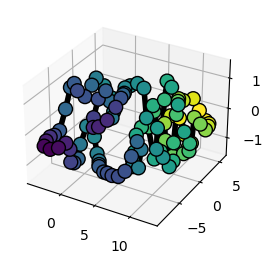

In [3]:
data = X_supercoil[1]
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(projection='3d')
scat = ax.scatter(data[:,1], data[:,0],data[:,2],s=100,edgecolors='black',alpha = 1, c = t[1])
ax.plot(data[:,1], data[:,0],data[:,2], linewidth=4, c = 'black')
plt.show()

In [4]:
def PH(X):
    df = pandas.DataFrame()
    for ii in range(X.shape[1]):
        df['x_{}'.format(ii)] =  X[:,ii]
    df.to_csv("pointcloud.tsv", sep = '\t', index = False)
    !julia ../src/PH.jl 
    with open('PH.json','r') as f:
        dic = json.load(f)
    return dic    

In [5]:
H_all = [PH(x) for x in tqdm(X_supercoil)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:53<00:00, 17.35s/it]


In [6]:
import hypernetx as hnx
import tpot

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [7]:
G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]

In [8]:
TOP_matchings = []
GEO_matchings = []
SOURCE = []
TARGET = []
VERT_matchings = []
for i in range(len(X_supercoil)-1):
    j = i+1
    df1 = topo_util.make_dataframe(H_all[i]["barcode"])
    df2 = topo_util.make_dataframe(H_all[j]["barcode"])
    p_spt = df1.iloc[:, 0:2].to_numpy()
    q_spt = df2.iloc[:, 0:2].to_numpy()
    p, q = pd.augmented_weights(p_spt, q_spt)
    C = pd.augmented_cost(p_spt, q_spt)
    pi = ot.emd(p, q, C)

    y0, w0, v0 = topo_util.process_hg(G_all[i], X_supercoil[i].shape[0])
    y1, w1, v1 = topo_util.process_hg(G_all[j], X_supercoil[j].shape[0])

    h = 0.25
    K0 = topo_util.get_kernel(X_supercoil[i], h)
    L0 = topo_util.symmetric_laplacian(K0)
    K0 /= K0.sum(-1).reshape(-1, 1)
    K1 = topo_util.get_kernel(X_supercoil[j], h)
    L1 = topo_util.symmetric_laplacian(K1)
    K1 /= K1.sum(-1).reshape(-1, 1)

    y0_imputed = topo_util.impute_laplacian(y0, L0)
    y1_imputed = topo_util.impute_laplacian(y1, L1)
    y0 = y0_imputed; y1 = y1_imputed;
    
    TARGET.append(y1)
    SOURCE.append(y0)
    C_v0 = sp.spatial.distance.cdist(X_supercoil[i], X_supercoil[i], metric = "euclidean"); C_v0 /= np.mean(C_v0)
    C_v1 = sp.spatial.distance.cdist(X_supercoil[j], X_supercoil[j], metric = "euclidean"); C_v1 /= np.mean(C_v1)
    C_pd = pd.augmented_cost(p_spt, q_spt)
    v0 = p
    v1 = q
    pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1,
                               C_v0, C_v1, C_pd, 
                               alpha = 0.5, beta = 10, print_iter = 50, iter = 100, 
                               solver = "exact")

    t0, t1 = t, t

    P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
    Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
    Q_pd = pi[:-1, :-1] / pi[:-1, :-1].sum(axis=-1)[:, np.newaxis]
    Q[np.isnan(Q)] = 0
    Q_pd[np.isnan(Q_pd)] = 0
    TOP_matchings.append(Q_pd)
    GEO_matchings.append(Q)
    VERT_matchings.append(P)


Iteration 0,	 obj = 0.18788556215419172,	 obj_terms = {'coot': 0.12866570066748112, 'ot': 0.056744970418157265, 'gw': 0.00247489106855332}
is_converged, obj = 0.1714172347479308, obj_new = 0.1714172347479308
Iteration 0,	 obj = 0.18977754469365402,	 obj_terms = {'coot': 0.1615815214786234, 'ot': 0.0256937591407913, 'gw': 0.002502264074239319}
is_converged, obj = 0.1628010967338776, obj_new = 0.1628010967338776
Iteration 0,	 obj = 0.18177001589218747,	 obj_terms = {'coot': 0.15985216154709453, 'ot': 0.02047474431727371, 'gw': 0.0014431100278192216}
is_converged, obj = 0.1563317681007177, obj_new = 0.1563317681007177
Iteration 0,	 obj = 0.15571847933944666,	 obj_terms = {'coot': 0.13593928037545078, 'ot': 0.018595674074318617, 'gw': 0.0011835248896772568}
is_converged, obj = 0.12670794643717057, obj_new = 0.12670794643717057


/tmp/ipykernel_690400/1100681868.py:46: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_690400/1100681868.py:47: RuntimeWarning:

invalid value encountered in divide



Iteration 0,	 obj = 0.21130282320769656,	 obj_terms = {'coot': 0.1795107888280038, 'ot': 0.02158214157571581, 'gw': 0.010209892803976942}
is_converged, obj = 0.14687405599688144, obj_new = 0.14687405599688144
Iteration 0,	 obj = 0.2791217226408964,	 obj_terms = {'coot': 0.20950595615427936, 'ot': 0.05836512814935259, 'gw': 0.011250638337264448}
is_converged, obj = 0.22090195692666775, obj_new = 0.22090195692666775
Iteration 0,	 obj = 0.24634090144642762,	 obj_terms = {'coot': 0.1987881992292367, 'ot': 0.04696764648378221, 'gw': 0.000585055733408682}
is_converged, obj = 0.21326063976601572, obj_new = 0.21326063976601572
Iteration 0,	 obj = 0.131235410631862,	 obj_terms = {'coot': 0.09716521856574034, 'ot': 0.0337991007570032, 'gw': 0.0002710913091184691}
is_converged, obj = 0.11532269186509535, obj_new = 0.11532269186509535
Iteration 0,	 obj = 0.18159862752140477,	 obj_terms = {'coot': 0.1041031406066982, 'ot': 0.07669162203877902, 'gw': 0.0008038648759275507}
is_converged, obj = 0.1735

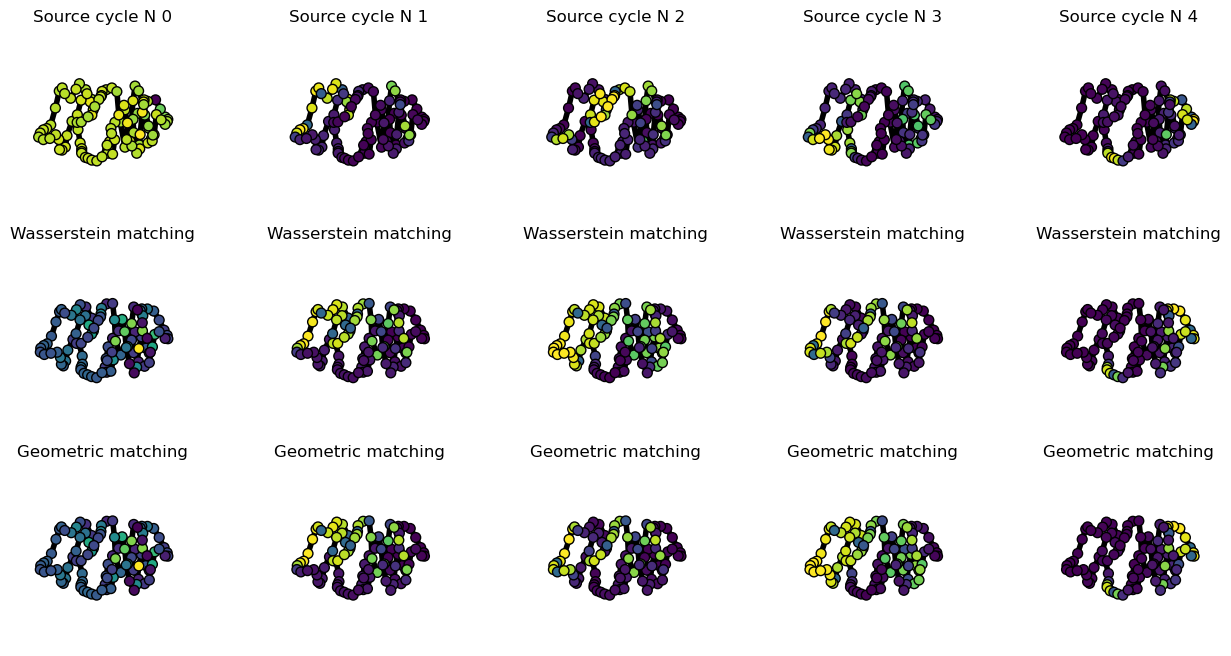

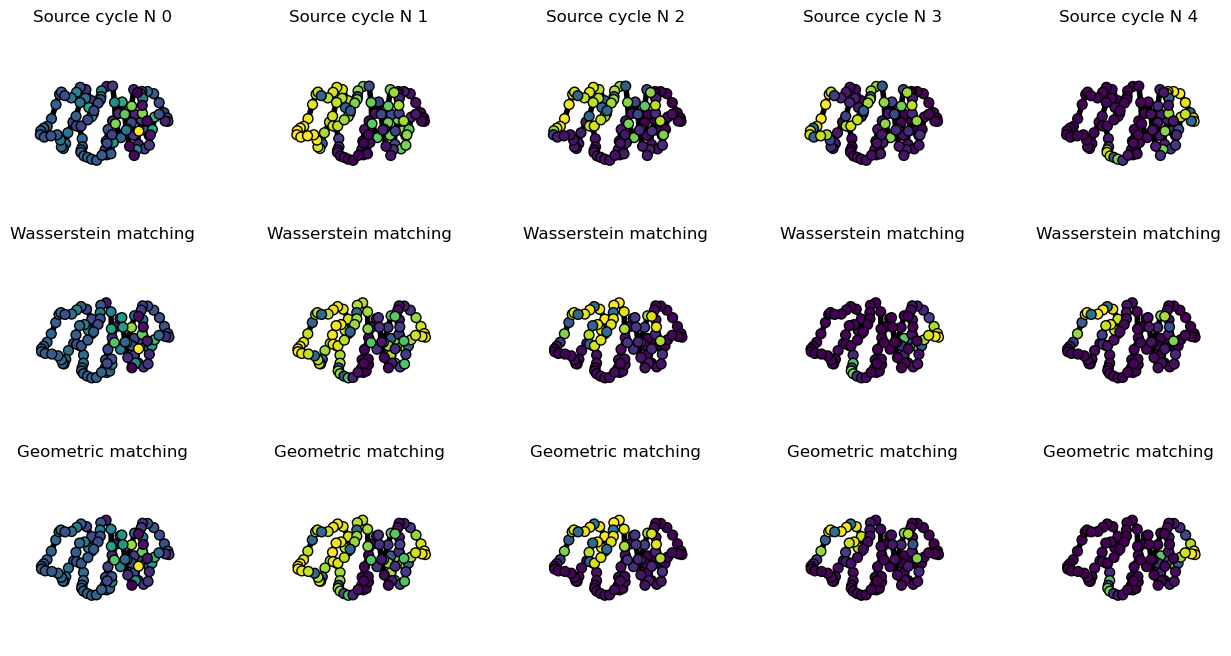

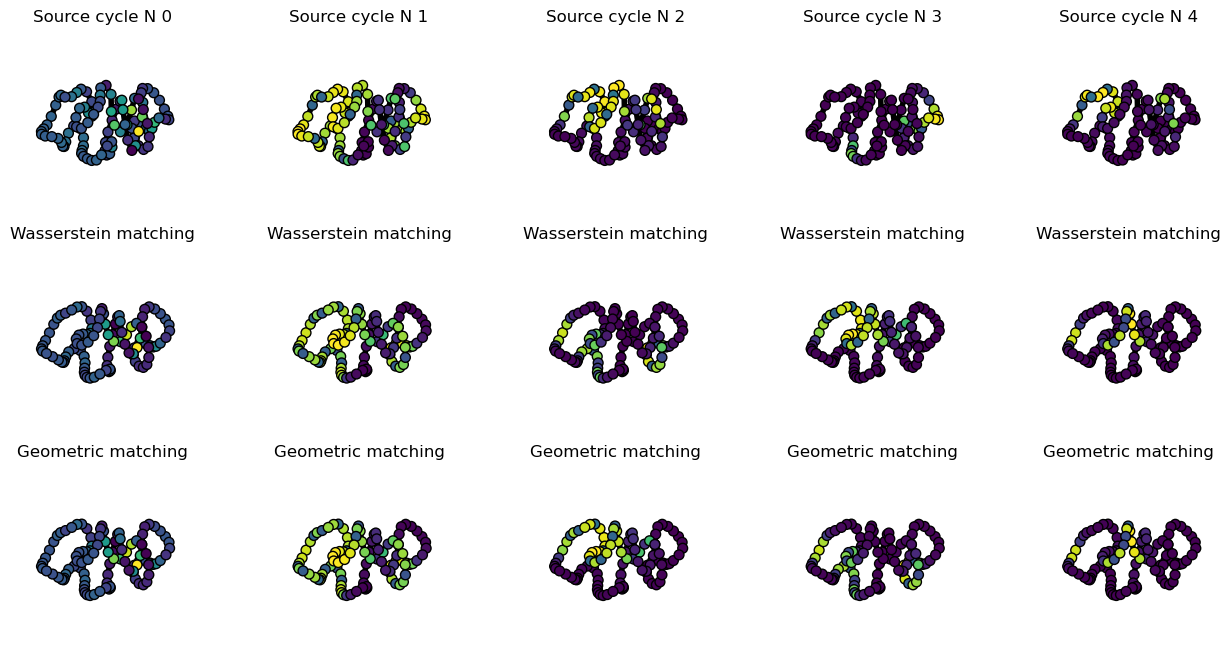

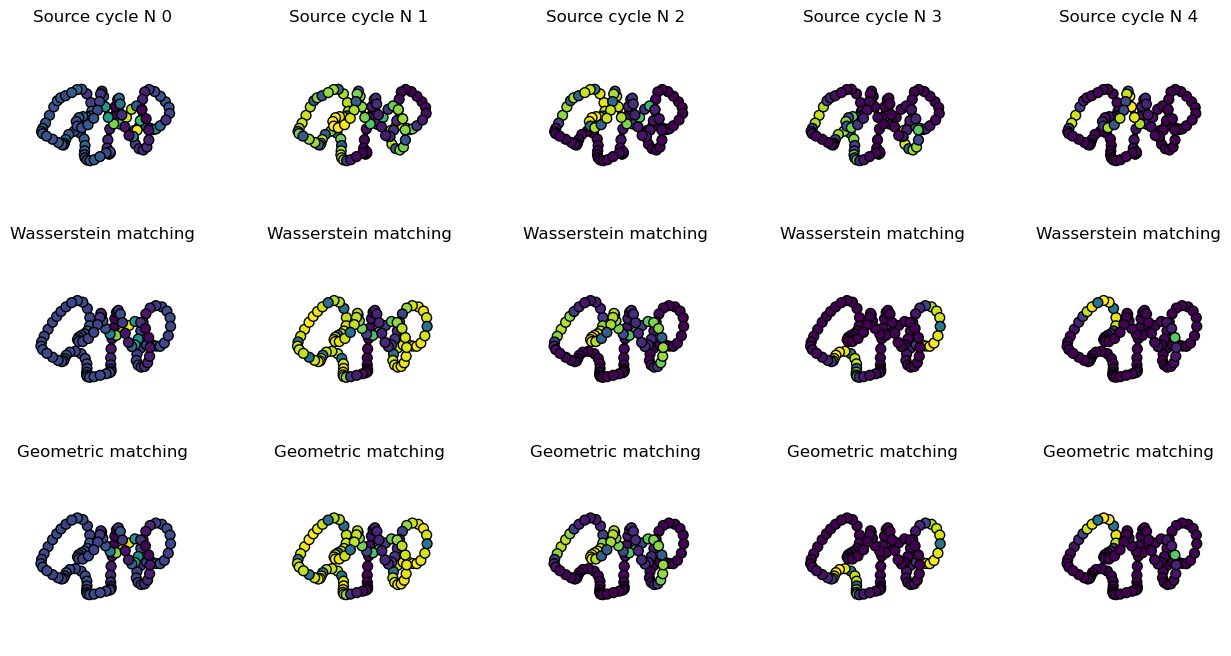

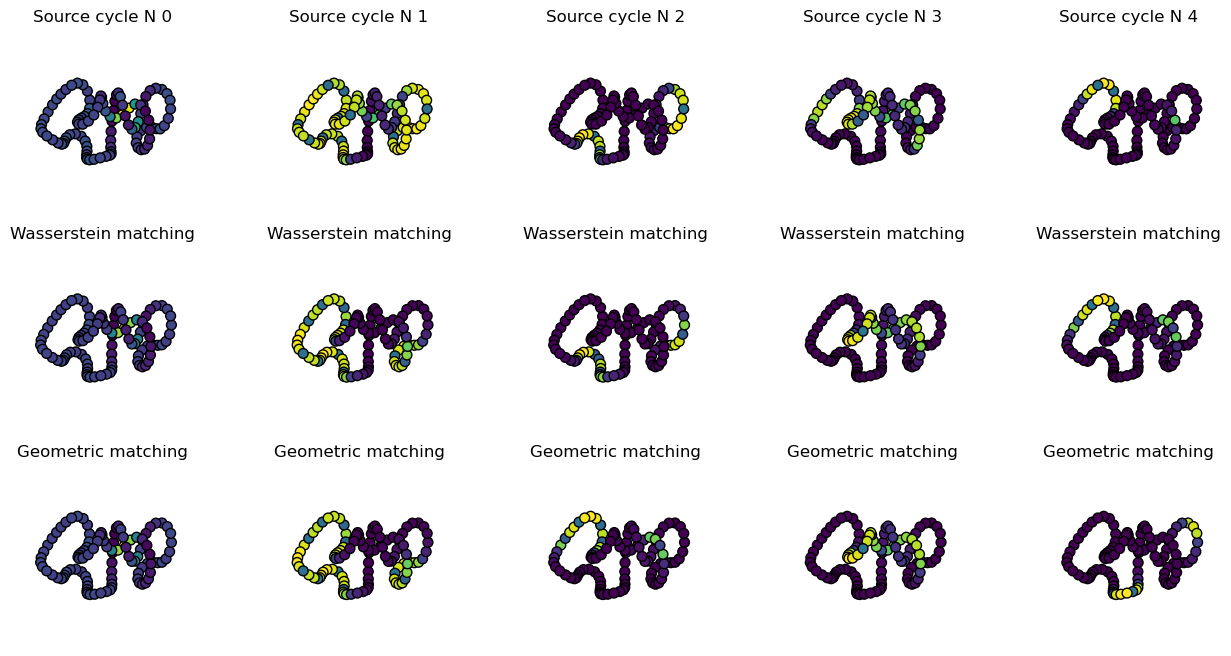

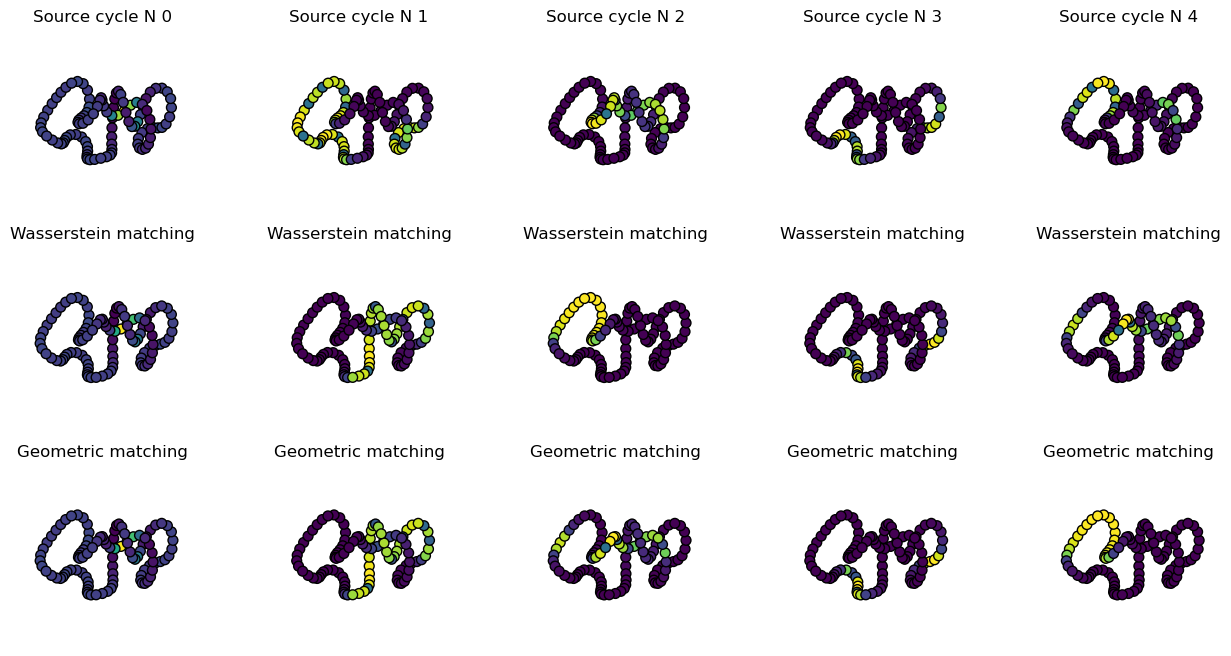

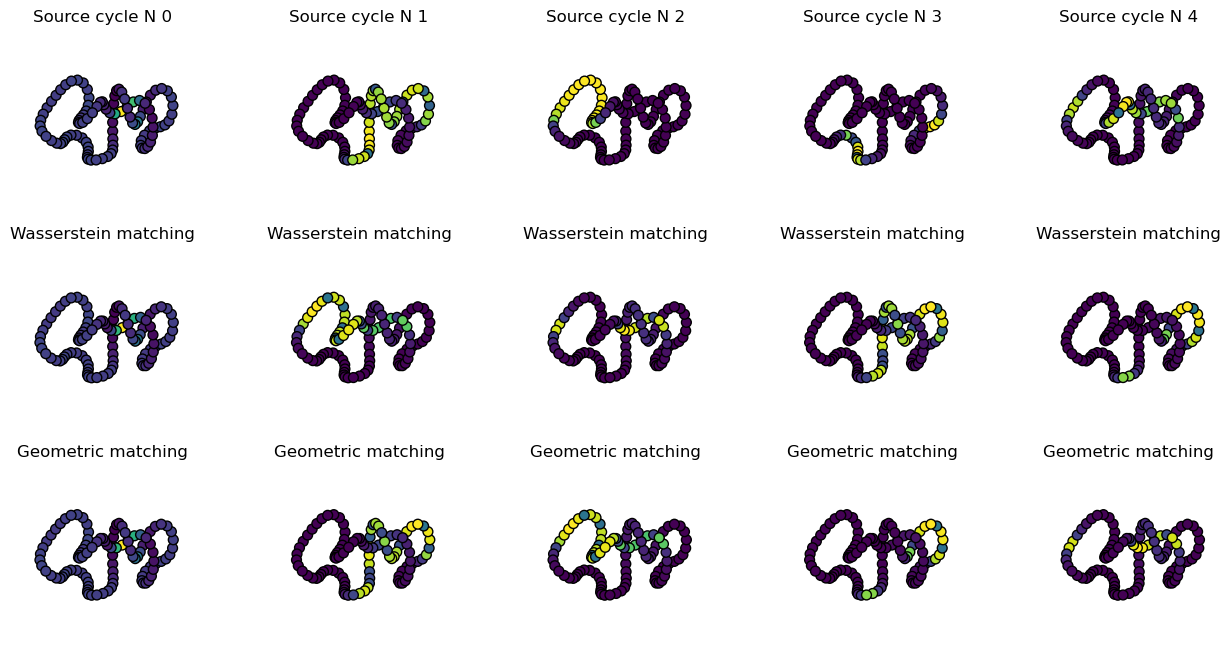

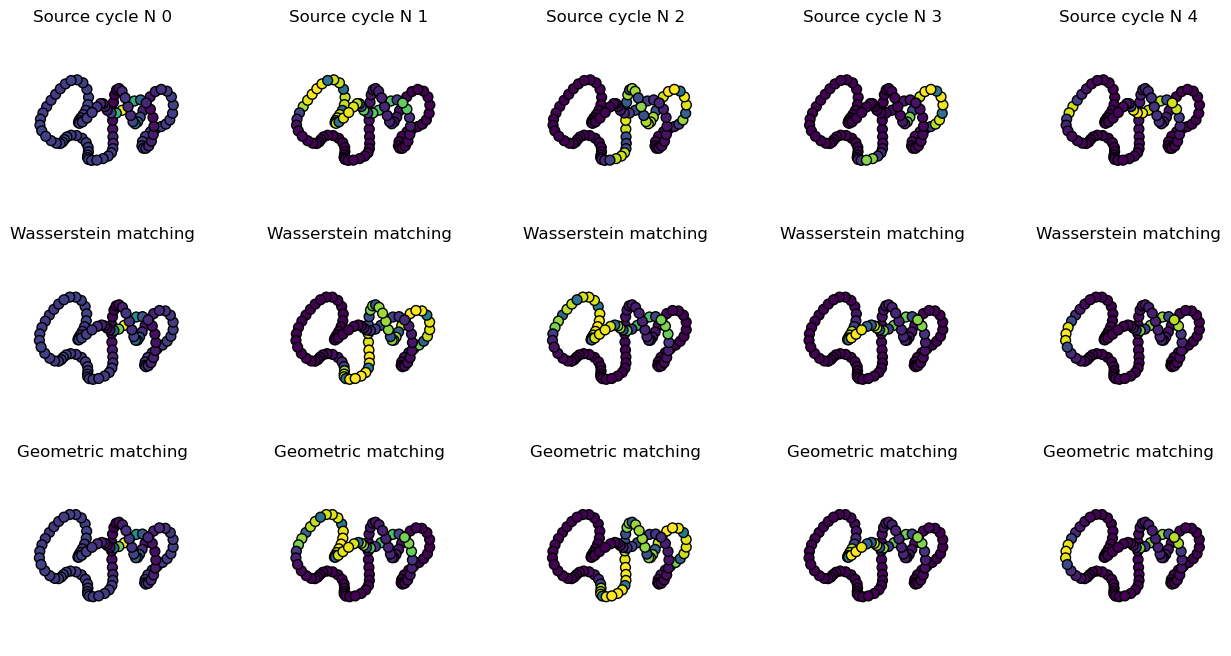

In [9]:
for i in range(1,len(X_supercoil)-1):
    y0 = SOURCE[i]
    Q = GEO_matchings[i]
    Q_pd = TOP_matchings[i]
    y1 = TARGET[i]
    A = X_supercoil[i]
    B = X_supercoil[i+1]
    fig = plt.figure(figsize=plt.figaspect(0.5))

    for l in range(1,6):
        ax = fig.add_subplot(3, 5, l,projection='3d')
        scat = ax.scatter(A[:,1], A[:,0],A[:,2],s=50,edgecolors='black',alpha = 1, c = y0[:, -l],)
        ax.plot(A[:,1], A[:,0],A[:,2], linewidth=4, c = 'black')
        ax.set_axis_off()
        plt.title("Source cycle N {}".format(l-1))
                          
        ax = fig.add_subplot(3, 5, l+5,projection='3d')
        scat = ax.scatter(B[:,1], B[:,0],B[:,2],s=50,edgecolors='black',alpha = 1, c = (Q_pd[-l, :].reshape(1, -1) * y1).sum(-1),)
        ax.plot(B[:,1], B[:,0],B[:,2], linewidth=4, c = 'black')
        ax.set_axis_off()
        plt.title("Wasserstein matching")

        ax = fig.add_subplot(3, 5, l+10,projection='3d')
        scat = ax.scatter(B[:,1], B[:,0],B[:,2],s=50,edgecolors='black',alpha = 1, c = (Q[-l, :].reshape(1, -1) * y1).sum(-1),)
        ax.plot(B[:,1], B[:,0],B[:,2], linewidth=4, c = 'black')
        ax.set_axis_off()    
        plt.title("Geometric matching")


    plt.show()
    fig.savefig('supercoil_step{}.png'.format(i))


In [10]:
corr = []
corr1 = []
pers = []
for i in range(len(X_supercoil)-1):
    y0 = SOURCE[i]
    Q = GEO_matchings[i]
    Q_pd = TOP_matchings[i]
    y1 = TARGET[i]
    A = X_supercoil[i]
    B = X_supercoil[i+1]
    for l in range(1,len(Q_pd)+1):
        corr1.append(np.corrcoef((Q_pd[-l, :].reshape(1, -1) * np.array(y1)).sum(-1), y0[:, -l])[0][1])
        corr.append(np.corrcoef((Q[-l, :].reshape(1, -1) * np.array(y1)).sum(-1), y0[:, -l])[0][1] ) 
        pers.append(H_all[i]['barcode'][1][-l] - H_all[i]['barcode'][0][-l])
corr = np.array(corr)
corr[np.isnan(corr)] = 0
corr1 = np.array(corr1)
corr1[np.isnan(corr1)] = 0

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



In [11]:
DF = pandas.DataFrame()
DF['Correlation'] = np.concatenate([corr1, corr])
DF['Type'] = np.concatenate([len(corr)*['Wasserstein'], len(corr)*['Geometric']])
DF['Persistence'] = np.concatenate([pers, pers])
DF

,Correlation,Type,Persistence
0,0.067853,Wasserstein,3.655392
1,-0.149594,Wasserstein,2.582456
2,-0.035992,Wasserstein,2.355960
3,0.579867,Wasserstein,1.665383
4,0.000000,Wasserstein,0.932369
...,...,...,...
227,0.396060,Geometric,0.037531
228,0.000000,Geometric,0.033797
229,0.000000,Geometric,0.026676
230,0.395050,Geometric,0.012195


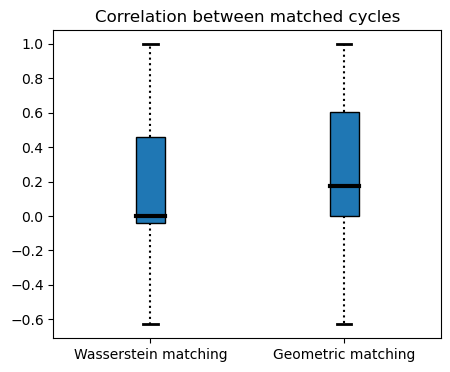

In [12]:
data = [DF.loc[DF['Type'] == 'Wasserstein']['Correlation'], DF.loc[DF['Type'] == 'Geometric']['Correlation']]

 
fig = plt.figure(figsize =(5, 4))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True, vert = 1)
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='black',
            linewidth = 2)
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='black',
              alpha = 0.5)
     
# x-axis labels
ax.set_xticklabels(['Wasserstein matching', 'Geometric matching', 
                    ])
 
# Adding title 
plt.title("Correlation between matched cycles")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()

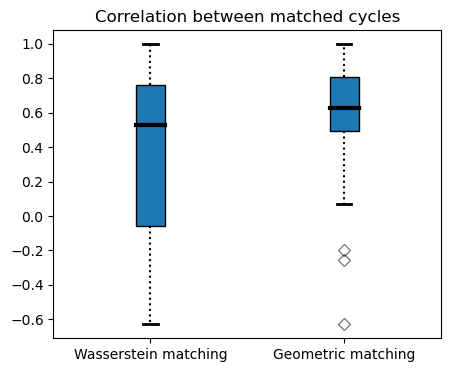

In [13]:
D = DF.loc[DF['Persistence'] > 1]
data = [D.loc[DF['Type'] == 'Wasserstein']['Correlation'], D.loc[D['Type'] == 'Geometric']['Correlation']]
fig = plt.figure(figsize =(5, 4))
ax = fig.add_subplot(111)
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True, vert = 1)
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='black',
            linewidth = 2)
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='black',
              alpha = 0.5)
# x-axis labels
ax.set_xticklabels(['Wasserstein matching', 'Geometric matching', 
                    ])
# Adding title 
plt.title("Correlation between matched cycles")
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
# show plot
plt.show()